In [2]:
!pip -q install pytorch-lightning
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset

print("Torch:", torch.__version__)
print("Lightning:", pl.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

Torch: 2.10.0+cu128
Lightning: 2.6.1


'cuda'

In [4]:
def synthetic_function_np(X: np.ndarray) -> np.ndarray:
    x1, x2, x3 = X[:, 0], X[:, 1], X[:, 2]
    y = np.sin(x1) + 0.3*(x2**2) - np.exp(-x3) + 0.1*x1*x2*x3
    return y.reshape(-1, 1)

def make_dataset(n=6000, seed=1, noise_std=0.05):
    rng = np.random.default_rng(seed)
    x1 = rng.uniform(-3.0, 3.0, size=(n, 1))
    x2 = rng.uniform(-2.0, 2.0, size=(n, 1))
    x3 = rng.uniform(0.0, 4.0, size=(n, 1))
    X = np.concatenate([x1, x2, x3], axis=1)
    y = synthetic_function_np(X)
    y = y + rng.normal(0.0, noise_std, size=y.shape)
    return X.astype(np.float32), y.astype(np.float32)

def standardize_train_test(X, y, test_frac=0.2, seed=2):
    rng = np.random.default_rng(seed)
    n = X.shape[0]
    idx = rng.permutation(n)
    n_test = int(n * test_frac)
    test_idx, train_idx = idx[:n_test], idx[n_test:]

    Xtr, Xte = X[train_idx], X[test_idx]
    ytr, yte = y[train_idx], y[test_idx]

    X_mean, X_std = Xtr.mean(0, keepdims=True), Xtr.std(0, keepdims=True) + 1e-8
    y_mean, y_std = ytr.mean(0, keepdims=True), ytr.std(0, keepdims=True) + 1e-8

    Xtr = (Xtr - X_mean) / X_std
    Xte = (Xte - X_mean) / X_std
    ytr = (ytr - y_mean) / y_std
    yte = (yte - y_mean) / y_std

    norms = dict(X_mean=X_mean, X_std=X_std, y_mean=y_mean, y_std=y_std)
    return Xtr, ytr, Xte, yte, norms


In [5]:
def plot_parity(y_true, y_pred, title="Predicted vs Actual"):
    plt.figure()
    plt.scatter(y_true.flatten(), y_pred.flatten(), s=8, alpha=0.6)
    lo = min(y_true.min(), y_pred.min())
    hi = max(y_true.max(), y_pred.max())
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()

def plot_4d_pca(X, y, title="4D plot: PCA(X)->3D, color=y"):
    pca = PCA(n_components=3)
    Xp = pca.fit_transform(X)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(Xp[:,0], Xp[:,1], Xp[:,2], c=y.flatten(), s=8, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    fig.colorbar(sc, ax=ax, shrink=0.7, label="y (color)")
    plt.show()


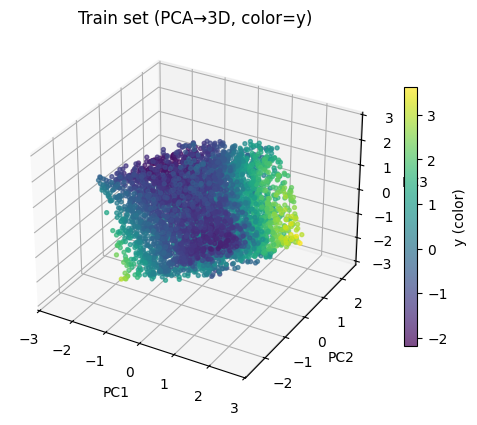

In [6]:
X, y = make_dataset(n=6000, seed=1, noise_std=0.05)
Xtr, ytr, Xte, yte, norms = standardize_train_test(X, y, test_frac=0.2, seed=2)

plot_4d_pca(Xtr, ytr, title="Train set (PCA→3D, color=y)")

train_ds = TensorDataset(torch.tensor(Xtr), torch.tensor(ytr))
test_ds = TensorDataset(torch.tensor(Xte), torch.tensor(yte))

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

In [7]:
class LitMLP(pl.LightningModule):
    def __init__(self, d_in=3, h1=64, h2=64, d_out=1, lr=1e-2):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Linear(d_in, h1),
            nn.Tanh(),
            nn.Linear(h1, h2),
            nn.Tanh(),
            nn.Linear(h2, d_out),
        )
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        yhat = self(x)
        loss = self.loss_fn(yhat, y)
        self.log("train_mse", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        yhat = self(x)
        loss = self.loss_fn(yhat, y)
        self.log("val_mse", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [8]:
model = LitMLP(lr=0.01)
trainer = pl.Trainer(max_epochs=20, accelerator="auto", devices="auto", log_every_n_steps=5)
trainer.fit(model, train_loader, test_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ net     │ Sequential │  4.5 K │ train │     0 │
│ 1 │ loss_fn │ MSELoss    │      0 │ train │     0 │
└───┴─────────┴────────────┴────────┴───────┴───────┘

Trainable params: 4.5 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.5 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 7                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)`
is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Test MSE (denormalized): 0.005914756562560797


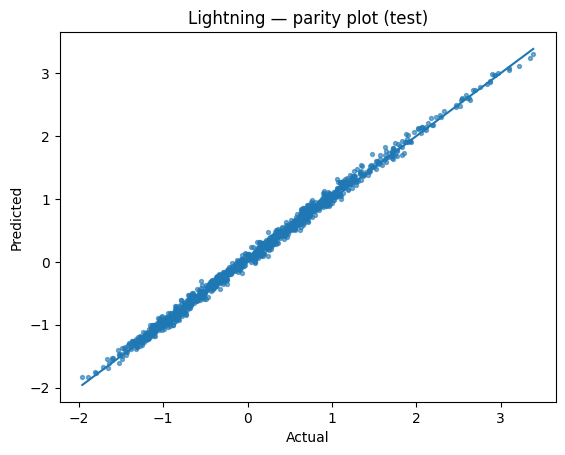

In [9]:
model.eval()
with torch.no_grad():
    yhat_te = model(torch.tensor(Xte)).numpy()

yhat_te_den = yhat_te * norms["y_std"] + norms["y_mean"]
yte_den = yte * norms["y_std"] + norms["y_mean"]
test_mse = np.mean((yhat_te_den - yte_den)**2)
print("Test MSE (denormalized):", float(test_mse))
plot_parity(yte_den, yhat_te_den, title="Lightning — parity plot (test)")